# Generalization

As a final experiment, we will try and find whether there exist any differences between the extent to which agents of different language are able to generalize. While we expect to find that all agents are able to generalize to a certain extent, some might be better able to generalize than others. This is based on the fact that agents seem to use completely different structures within their language, as is appointed by the problem area RSA figure. If structures are similar between languages, we will likely find that agents are able to generalize to similar extent. Differences in performance on new (not seen before) samples will indicate the degree of which structure in the created languages will differ.

In [3]:
import glob
import pickle
from metrics import *
import matplotlib.pyplot as plt
from scipy import spatial
from data import one_hot


In [4]:
# functions for loading data

def load_metrics(path):
    """
        This function loads metrics
    """

    # load the data
    seed_folders = glob.glob(f"{path}/*")

    # save results
    generalize_result = {}
    train_result = {}

    # run through all seed
    for s in seed_folders:

        # get seed index
        seed = s.split("/")[-1]
        
        # make sure to ignore the rsa analysis for now
        if seed == 'rsa_analysis.pkl':
            continue

        # get all metric files
        metric_files = glob.glob(s + "/*.pkl")

        for file in metric_files:

            # load files
            m1 = pickle.load(open(file, "rb"))

            # check if file is generalize or train metric
            if file.find('generalize') == -1:
                if file.find('9800') != -1:
                    train_result[seed] = m1
            else:
                generalize_result[seed] = m1                

    return train_result, generalize_result

def on_hot_hamming(a, b):
    return spatial.distance.hamming(
        one_hot(a, n_cols=VOCAB).flatten(), one_hot(b, n_cols=VOCAB).flatten()
    )

def levenshtein_ratio_and_distance(s, t):
    """ levenshtein_ratio_and_distance:
        Calculates levenshtein distance between two strings.
        If ratio_calc = True, the function computes the
        levenshtein distance ratio of similarity between two strings
        For all i and j, distance[i,j] will contain the Levenshtein
        distance between the first i characters of s and the
        first j characters of t
    """
    # Initialize matrix of zeros
    rows = len(s)+1
    cols = len(t)+1
    distance = np.zeros((rows,cols),dtype = int)

    # Populate matrix of zeros with the indeces of each character of both strings
    for i in range(1, rows):
        for k in range(1,cols):
            distance[i][0] = i
            distance[0][k] = k

    # Iterate over the matrix to compute the cost of deletions,insertions and/or substitutions
    for col in range(1, cols):
        for row in range(1, rows):
            if s[row-1] == t[col-1]:
                cost = 0 # If the characters are the same in the two strings in a given position
                         # [i,j] then the cost is 0
            else:
                # If we choose to calculate the ratio the cost of a substitution is 2.
                cost = 2

            distance[row][col] = min(distance[row-1][col] + 1,      # Cost of deletions
                                 distance[row][col-1] + 1,          # Cost of insertions
                                 distance[row-1][col-1] + cost)     # Cost of substitutions

    # Computation of the Levenshtein Distance Ratio
    Ratio = ((len(s)+len(t)) - distance[row][col]) / (len(s)+len(t))
    return Ratio


def get_similarity(train_data, generalize_data):

    # extract targets
    train_targets = train_data['targets']
    generalize_targets = generalize_data['targets']


    # extract messages
    train_messages = train_data['messages']
    generalize_messages = generalize_data['messages']

    # now check for the messages describing similar targets
    VOCAB = 25
    # get a target from the generalize set
    same_count = 0
    count = 0
    all_similarities = []

    for tar_i in range(len(generalize_targets)):

        target = generalize_targets[tar_i]

        for i, train_target in enumerate(train_targets):
            score = spatial.distance.hamming(target, train_target)

            # check if targets are close
            if score < 0.2:

                #print(generalize_messages[tar_i])
                #print(train_messages[i])
                #print()

                # now check for message distance
                similarity = levenshtein_ratio_and_distance(generalize_messages[tar_i], train_messages[i])

                # print(similarity)
                # print()

                all_similarities.append(similarity)
                
    return np.average(all_similarities)
   

# Choose a run

In [29]:
#path = "split_runs/90-10-split/lstm_max_len_10_vocab_25_attr_5_split"
path = "runs/lstm_max_len_10_vocab_25_attr_5_split"

train, generalize = load_metrics(path)

In [30]:
# what's next?
# first check whether targets in the generalize do not appear in the train

seed = '1'

# extract targets
train_targets = train[seed]['targets']
generalize_targets = generalize[seed]['targets']

count = 0
for target in train_targets:
    target = tuple(target)
    for target2 in generalize_targets:
        target2 = tuple(target2)
        if target == target2:
            count += 1
            
if count == 0:
    print('No same targets found')

# DONE

No same targets found


# Plot results

In [31]:
# plot code
def plot_results(generalize):
    
    
    fig, ax = plt.subplots(figsize=(15,8))
    
    index = np.arange(10)

    bar_width = 0.4
    opacity = 0.7
    
    all_acc = []
    # get the accuracy
    for i, seed in enumerate(sorted(generalize.keys())):
        
        # get the accuracy for the seed
        acc = generalize[seed]['acc']
        all_acc.append(acc)
        
    # plot the bar
    plt.bar(index + bar_width, all_acc, bar_width,
            alpha=opacity,
            label=seed)
    
    plt.ylabel('Accuracy')
    plt.title('Accuracy per seed')
    plt.xlabel('seed')
    plt.xticks(index + bar_width, tuple([i for i in sorted(generalize.keys())]))
        
    plt.show()
    return all_acc

# Accuracy at final iteration of training

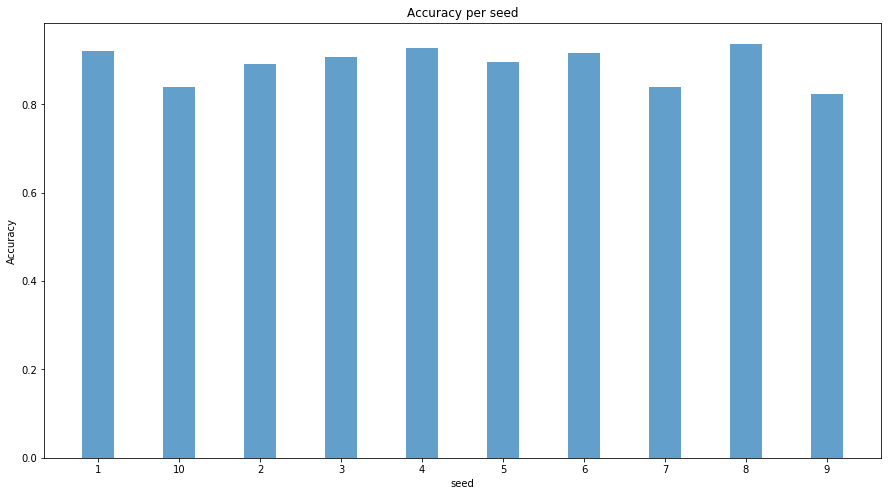


Accuracy for seed 1: 0.921875

Accuracy for seed 10: 0.8385416666666666

Accuracy for seed 2: 0.890625

Accuracy for seed 3: 0.90625

Accuracy for seed 4: 0.9270833333333334

Accuracy for seed 5: 0.8958333333333334

Accuracy for seed 6: 0.9166666666666666

Accuracy for seed 7: 0.8385416666666666

Accuracy for seed 8: 0.9375

Accuracy for seed 9: 0.8229166666666666


In [32]:
all_acc = plot_results(train)

for i, seed in enumerate(sorted(train.keys())):
    print()
    print('Accuracy for seed ' + seed + ': ' + str(all_acc[i]))

# Accuracy for newly seen samples

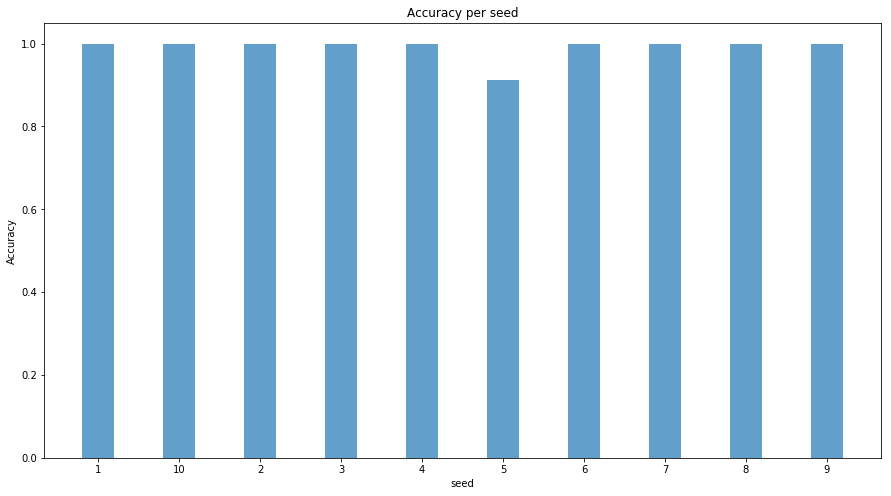


Accuracy for seed 1: 1.0

Accuracy for seed 10: 1.0

Accuracy for seed 2: 1.0

Accuracy for seed 3: 1.0

Accuracy for seed 4: 1.0

Accuracy for seed 5: 0.9131944477558136

Accuracy for seed 6: 1.0

Accuracy for seed 7: 1.0

Accuracy for seed 8: 1.0

Accuracy for seed 9: 1.0


In [24]:
all_acc = plot_results(generalize)

for i, seed in enumerate(sorted(generalize.keys())):
    print()
    print('Accuracy for seed ' + seed + ': ' + str(all_acc[i]))



In [33]:
def get_same_count(generalize, train):
    # now check for the messages describing similar targets
    VOCAB = 25
    # get a target from the generalize set
    same_count = 0
    count = 0
    #seed = '4'
    for tar_i in range(len(generalize['targets'])):

        target = generalize['targets'][tar_i]

        #print('Generalize message: ', generalize['messages'][tar_i])

        # extract targets
        train_targets = train['targets']
        generalize_targets = generalize['targets']

        # extract messages
        train_messages = train['messages']
        generalize_messages = generalize['messages']


        for i, train_target in enumerate(train_targets):
            score = spatial.distance.hamming(target, train_target)

            # check if targets are close
            if score < 0.2:
                
                # keep track of the amount of similar targets               
                count += 1
                
                # check whether the messages are identical for these similar targets
                if tuple(train_messages[i]) == tuple(generalize_messages[tar_i]):
                    same_count += 1
                    
    return same_count, count


# Nr of identical messages
But how many of the targets actually produce identical messages?

In [34]:
for seed in sorted(train.keys()):
    #print('For seed ' + str(seed) + ', we find the following amount of identical messages:')
    same_count, count = get_same_count(generalize[seed], train[seed])
    print(same_count, '/', count)

#print(same_count, '/', count)  

7 / 162
12 / 162
43 / 162
30 / 162
20 / 162
118 / 162
5 / 162
15 / 162
22 / 162
27 / 162


How identical are the messages? Compared to the targets?

In [35]:
from itertools import combinations

generalize_messages = generalize[seed]['messages']

similarities = []
for (message1, message2) in combinations(generalize_messages, 2):
    similarity = levenshtein_ratio_and_distance(message1,message2)
    similarities.append(similarity)

print(np.average(similarities))        

distances = []
for (target1, target2) in combinations(generalize_targets, 2):
    distance = spatial.distance.hamming(target1, target2)
    distances.append(distance)
    
print(np.average(distances))

0.5565095398428731
0.35999999999999993


Do the others resemble any similarities? Let's try and show that by checking at the distances between the messages

In [38]:
# go through all seeds
print()
for seed in sorted(train.keys()):
    
    sim = get_similarity(train[seed], generalize[seed])
    print('Seed ' + str(seed) + ': \t' + str(sim))


Seed 1: 	0.5622895622895623
Seed 10: 	0.46071829405162734
Seed 2: 	0.904040404040404
Seed 3: 	0.8058361391694724
Seed 4: 	0.6335578002244668
Seed 5: 	0.9702581369248037
Seed 6: 	0.557800224466891
Seed 7: 	0.5892255892255891
Seed 8: 	0.6638608305274971
Seed 9: 	0.7912457912457913


### Note that there exist pretty big differences between the train and generalize messages per initialization

# Conclusion

So far we have a couple of reasons to believe that agents actually hash new objects that they see.

First of all, if we use just a small proportion of the data for the generalization, we find that a lot of the messages (1/5) are the exact same for samples that they have not seen before.

Second, if we however use a large proportion of the data for generalization, we find that messages that are used for these newly seen objects are extremely similar. Which, they should not be.

The more data we use for generalization, the more similar the messages. This is in favour of the hash hypothesis. They have never seen this new target so they do not at all match it with what they currently know, instead they just try something new.

### Main finding: the more targets are unknown to the model, the more similar the messages that describe these targets are.

# What's next

Maybe check message similarity for the same targets, this will remove any data biases that might cause this effect.